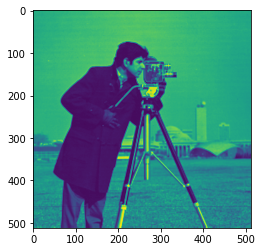

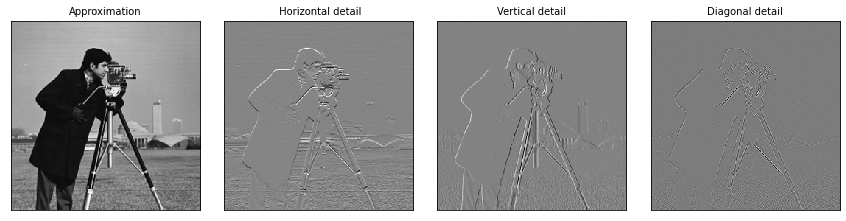

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit

import pywt
import pywt.data


# Load image
original = pywt.data.camera()

plt.imshow(original)

# Wavelet transform of image, and plot approximation and details
titles = ['Approximation', ' Horizontal detail',
          'Vertical detail', 'Diagonal detail']
coeffs2 = pywt.dwt2(original, 'bior1.3')
LL, (LH, HL, HH) = coeffs2
fig = plt.figure(figsize=(12, 3))
for i, a in enumerate([LL, LH, HL, HH]):
    ax = fig.add_subplot(1, 4, i + 1)
    ax.imshow(a, interpolation="nearest", cmap=plt.cm.gray)
    ax.set_title(titles[i], fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])

fig.tight_layout()
plt.show()

In [3]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from skimage.io import imread

def keypoints(file):
    img = cv2.imread(file,0)
    
    fast = cv2.FastFeatureDetector_create(threshold=15)
    kp = fast.detect(img,None)
    
    img2 = cv2.drawKeypoints(img, kp, None,color=(255,0,0))

    print("Threshold: ", fast.getThreshold())
    print("nonmaxSuppression: ", fast.getNonmaxSuppression())
    print("neighborhood: ", fast.getType())
    print("Total Keypoints with nonmaxSuppression: ", len(kp))

    cv2.imwrite('fast_true.png',img2)
    plt.imshow(imread("fast_true.png"))

Threshold:  15
nonmaxSuppression:  True
neighborhood:  2
Total Keypoints with nonmaxSuppression:  92


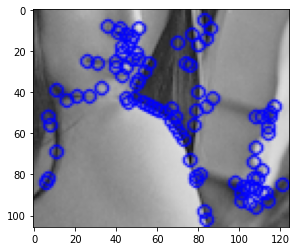

In [4]:
keypoints("Lenna3.png")

Threshold:  15
nonmaxSuppression:  True
neighborhood:  2
Total Keypoints with nonmaxSuppression:  768


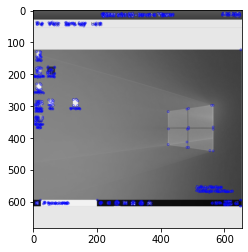

In [5]:
keypoints("s1.png")

In [6]:
import cv2

def orb(file1, file2, count=50):
    img1 = cv2.imread(file1, 0)
    img2 = cv2.imread(file2, 0)

    orb = cv2.ORB_create()
    kp1, des1 = orb.detectAndCompute(img1, None)
    kp2, des2 = orb.detectAndCompute(img2, None)
    
    if des1 is None or des2 is None:
        return

    # matcher takes normType, which is set to cv2.NORM_L2 for SIFT and SURF, cv2.NORM_HAMMING for ORB, FAST and BRIEF
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(des1, des2)
    matches = sorted(matches, key=lambda x: x.distance)# draw first 'count' matches
    match_img = cv2.drawMatches(img1, kp1, img2, kp2, matches[:count], None)
    cv2.imwrite('Matches.png',match_img)
    return kp1, des1, kp2, des2, matches

In [7]:
def detect_compute(img, detector, computer):
    kp = detector.detect(img, None)
    return computer.compute(img, kp)

In [8]:
def fast_hog(file1, file2, count=50, threshold=10):
    img1 = cv2.imread(file1, 0)
    img2 = cv2.imread(file2, 0)

    fast = cv2.FastFeatureDetector_create(threshold=threshold)
    winSize = (32,32)
    blockSize = (16,16)
    blockStride = (8,8)
    cellSize = (8,8)
    nbins = 9
    derivAperture = 1
    winSigma = 4.
    histogramNormType = 0
    L2HysThreshold = 2.0000000000000001e-01
    gammaCorrection = 0
    nlevels = 64
    hog = cv2.HOGDescriptor(winSize,blockSize,blockStride,cellSize,nbins,derivAperture,winSigma,
                            histogramNormType,L2HysThreshold,gammaCorrection,nlevels)
    
    winStride = (32,32)
    padding = (32,32)
    kp1 = fast.detect(img1, None)
    kp2 = fast.detect(img2, None)
    des1 = hog.compute(img1,winStride,padding,[k.pt for k in kp1])
    des2 = hog.compute(img2,winStride,padding,[k.pt for k in kp2])
    
    if des1 is None or des2 is None:
        return
    
    des1, des2 = np.array(des1).reshape((len(kp1),-1)), np.array(des2).reshape((len(kp2),-1))
    
    print(len(kp1), len(kp2), des1.shape, des2.shape)

    # matcher takes normType, which is set to cv2.NORM_L2 for SIFT and SURF, cv2.NORM_HAMMING for ORB, FAST and BRIEF
    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
    matches = bf.match(des1, des2)
    matches = sorted(matches, key=lambda x: x.distance)# draw first 'count' matches
    match_img = cv2.drawMatches(img1, kp1, img2, kp2, matches[:count], None)
    cv2.imwrite('Matches.png',match_img)
    return kp1, des1, kp2, des2, matches[:count]

In [9]:
def fast_freak(file1, file2, count=50, threshold=0):
    img1 = cv2.imread(file1)
    img2 = cv2.imread(file2)

    fast = cv2.FastFeatureDetector_create(threshold=threshold)
    freakExtractor = cv2.xfeatures2d.FREAK_create()
    kp1,des1 = detect_compute(img1, fast, freakExtractor)
    kp2,des2 = detect_compute(img2, fast, freakExtractor)

    if des1 is None or des2 is None:
        return
    
    print(len(kp1), len(kp2), len(des1.shape), len(des2))

    # matcher takes normType, which is set to cv2.NORM_L2 for SIFT and SURF, cv2.NORM_HAMMING for ORB, FAST and BRIEF
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(des1, des2)
    matches = sorted(matches, key=lambda x: x.distance)
    match_img = cv2.drawMatches(img1, kp1, img2, kp2, matches[:count], None)
    cv2.imwrite('Matches.png', match_img)
    return kp1, des1, kp2, des2, matches[:count]

In [13]:
def good_kp(frame):
    gray = frame
    if len(frame.shape) != 2:
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    corners = cv2.goodFeaturesToTrack(gray, mask=None, maxCorners=10000, qualityLevel=0.00001, minDistance=1, blockSize=1)
    corners = np.int0(corners)
    corners = [corner.ravel() for corner in corners]
    for corner in corners:
        cv2.circle(frame, (corner[0], corner[1]), 3, [0,255,0], -1)
    cv2.imwrite('Matches.png', frame)
    return corners

In [14]:
def good_hog(file1, file2, count=50, threshold=None):
    img1 = cv2.imread(file1, 0)
    img2 = cv2.imread(file2,0)

    winSize = (16,16)
    blockSize = (16,16)
    blockStride = (8,8)
    cellSize = (8,8)
    nbins = 9
    derivAperture = 1
    winSigma = 4.
    histogramNormType = 0
    L2HysThreshold = 2.0000000000000001e-01
    gammaCorrection = 0
    nlevels = 64
    hog = cv2.HOGDescriptor(winSize,blockSize,blockStride,cellSize,nbins,derivAperture,winSigma,
                            histogramNormType,L2HysThreshold,gammaCorrection,nlevels)
    
    winStride = (32,32)
    padding = (32,32)
    kp1 = good_kp(img1)
    kp2 = good_kp(img2)
    des1 = hog.compute(img1,winStride,padding, kp1)
    des2 = hog.compute(img2,winStride,padding, kp2)
    
    if des1 is None or des2 is None:
        return
    
    des1, des2 = np.array(des1).reshape((len(kp1),-1)), np.array(des2).reshape((len(kp2),-1))
    
    print(des1.shape, des2.shape)
    
    #des1 = np.array([[*d, *img1[kp1[idx][1]][kp1[idx][0]]] for idx, d in enumerate(des1)])
    #des2 = np.array([[*d, *img2[kp2[idx][1]][kp2[idx][0]]] for idx, d in enumerate(des2)])
    
    print(des1.shape, des2.shape)

    # matcher takes normType, which is set to cv2.NORM_L2 for SIFT and SURF, cv2.NORM_HAMMING for ORB, FAST and BRIEF
    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
    matches = bf.match(des1, des2)
    matches = sorted(matches, key=lambda x: x.distance)# draw first 'count' matches
    kp1 = [cv2.KeyPoint(float(p[0]), float(p[1]), 1) for p in kp1]
    kp2 = [cv2.KeyPoint(float(p[0]), float(p[1]), 1) for p in kp2]
    match_img = cv2.drawMatches(img1, kp1, img2, kp2, matches[:count], None)
    cv2.imwrite('Matches.png',match_img)
    return kp1, des1, kp2, des2, matches

962 756 (962, 324) (756, 324)


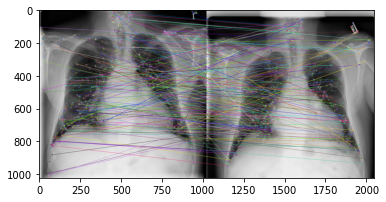

In [15]:
kp1, des1, kp2, des2, matches = fast_hog("00000001_000.png", "00000001_001.png", 500, threshold=10)
plt.imshow(imread("Matches.png"))

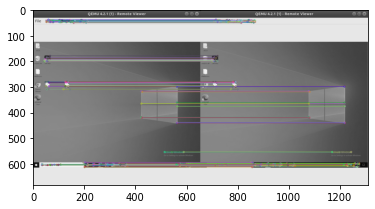

In [16]:
kp1, des1, kp2, des2, matches = orb("s1.png", "s1.png", 50000)
plt.imshow(imread("Matches.png"))

In [19]:
def remove_kp(img1, kp1, img2, kp2, matches, align=64, aligned=True):
    a = align
    img11 = np.zeros(((img1.shape[0] + a - 1) // a * a, (img1.shape[1] + a - 1) // a * a, 3), dtype='uint8')
    img22 = np.zeros(((img2.shape[0] + a - 1) // a * a, (img2.shape[1] + a - 1) // a * a, 3), dtype='uint8')
    if len(img1.shape) != 2 and img1.shape[2] > 3:
        img11[:img1.shape[0], :img1.shape[1]] = img1[:,:,:3]
        img22[:img2.shape[0], :img2.shape[1]] = img2[:,:,:3]
    elif len(img1.shape) == 2:
        img11[:img1.shape[0], :img1.shape[1]] = cv2.cvtColor(img1, cv2.COLOR_GRAY2BGR)
        img22[:img2.shape[0], :img2.shape[1]] = cv2.cvtColor(img2, cv2.COLOR_GRAY2BGR)
    else:
        img11[:img1.shape[0], :img1.shape[1]] = img1
        img22[:img2.shape[0], :img2.shape[1]] = img2
    
    plt.imshow(img11)
    plt.show()
    plt.imshow(img22)
    plt.show()
    
    mapped = dict()
    
    img33 = np.zeros_like(img22)
    
    
    for m in reversed(matches):
        p1, p2 = (int(kp1[m.queryIdx].pt[0]), int(kp1[m.queryIdx].pt[1])), (int(kp2[m.trainIdx].pt[0]), int(kp2[m.trainIdx].pt[1]))
        p1 = (p1[1], p1[0])
        p2 = (p2[1], p2[0])
        ap1 = p1
        ap2 = p2
        if aligned:
            delta = (p2[0] - p2[0] // a * a, p2[1] - p2[1] // a * a)
            ap1 = (p1[0] - delta[0], p1[1] - delta[1])
            ap2 = (p2[0] // a * a, p2[1] // a * a)
        if not (0 <= ap2[1] <= img22.shape[1] - a and 
                0 <= ap2[0] <= img22.shape[0] - a):
            continue
        if not (0 <= ap1[1] <= img11.shape[1] - a and 
                0 <= ap1[0] <= img11.shape[0] - a):
            continue
        mapped[ap2] = ap1
        
        img33[ap2[0]: ap2[0] + a, ap2[1]: ap2[1] + a] = img11[ap1[0] : ap1[0] + a, ap1[1]: ap1[1] + a]
        
    plt.imshow(img33)
    plt.show()
    
    #imgdiff = np.zeros((a, len(mapped) * a, 3), dtype='uint8')
    imgdiff = np.zeros((a, len(mapped) * a, 3), dtype=int)
    signs = np.zeros_like(imgdiff)
    imgleft = np.zeros((a, img22.shape[0] * img22.shape[1] // a - len(mapped) * a, 3), dtype='uint8')
    diffidx = 0
    leftidx = 0
    for i in range(img22.shape[0] // a):
        for j in range(img22.shape[1] // a):
            if (i * a,j * a) in mapped:
                v = mapped[(i * a,j * a)]
                signs[:, diffidx * a: (diffidx + 1) * a] = img22[i * a: (i + 1) * a, j * a: (j + 1) * a] >= img11[v[0]: v[0] + a,v[1]: v[1] + a]
                imgdiff[:, diffidx * a: (diffidx + 1) * a] = np.abs(img22[i * a: (i + 1) * a, j * a: (j + 1) * a].astype(int) - img11[v[0]: v[0] + a,v[1]: v[1] + a].astype(int))
                #imgdiff[:, diffidx * a: (diffidx + 1) * a] = img22[i * a: (i + 1) * a, j * a: (j + 1) * a, :-1].astype(int) - img11[v[0]: v[0] + a,v[1]: v[1] + a, :-1].astype(int)
                diffidx += 1
            else:
                imgleft[:, leftidx * a: (leftidx + 1) * a] = img22[i * a: (i + 1) * a, j * a: (j + 1) * a]
                leftidx += 1
    return signs, mapped, imgdiff, imgleft

In [22]:
def place_kp(img1, img2, signs, mapped, imgdiff, imgleft, align=64):
    a = align
    img11 = np.zeros(((img1.shape[0] + a - 1) // a * a, (img1.shape[1] + a - 1) // a * a, 3), dtype=int)
    img22 = np.zeros(((img2.shape[0] + a - 1) // a * a, (img2.shape[1] + a - 1) // a * a, 3), dtype='uint8')
    if len(img1.shape) != 2 and img1.shape[2] == 4:
        img11[:img1.shape[0], :img1.shape[1], :] = img1[:,:,:-1]
        img22[:img2.shape[0], :img2.shape[1], :] = img2[:,:,:-1]
    else:
        img11[:img1.shape[0], :img1.shape[1]] = cv2.cvtColor(img1, cv2.COLOR_GRAY2BGR)
        img22[:img2.shape[0], :img2.shape[1]] = cv2.cvtColor(img2, cv2.COLOR_GRAY2BGR)
    diffidx = 0
    leftidx = 0
    sign = np.zeros((a,a,3), dtype=int)
    for i in range(img22.shape[0] // a):
        for j in range(img22.shape[1] // a):
            if (i * a,j * a) in mapped:
                v = mapped[(i * a,j * a)]
                sign[:] = -1
                sign[signs[:, diffidx * a: (diffidx + 1) * a]] = 1
                img22[i * a: (i + 1) * a, j * a: (j + 1) * a] = np.clip(img11[v[0]: v[0] + a,v[1]: v[1] + a] + imgdiff[:, diffidx * a: (diffidx + 1) * a]*sign, a_min=0, a_max=255)
                diffidx += 1
            else:
                img22[i * a: (i + 1) * a, j * a: (j + 1) * a] = imgleft[:, leftidx * a: (leftidx + 1) * a]
                leftidx += 1
    plt.imshow(img22)
    plt.show()
    return img22[:img2.shape[0], :img2.shape[1]]

14572 15003 (14572, 324) (15003, 324)


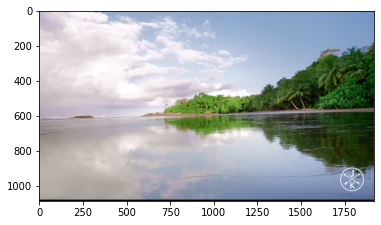

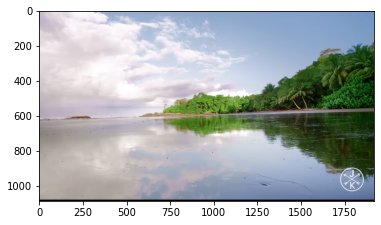

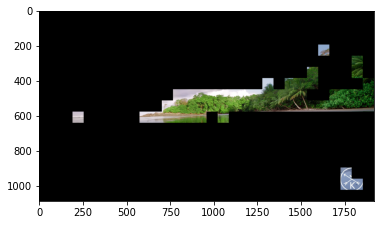

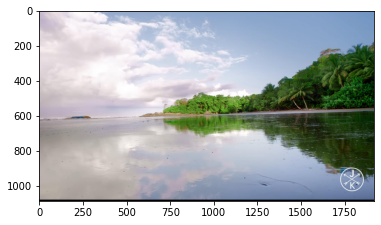

In [24]:
def test(file1, file2):
    kp1, des1, kp2, des2, matches = fast_hog(file1, file2, count=1800,threshold=10)
    img1, img2 = imread(file1), imread(file2)
    align = 64
    signs, mapped, imgdiff, imgleft = remove_kp(img1, kp1, img2, kp2, matches, align=align)
    cv2.imwrite("DIFF.jpg", imgdiff, [int(cv2.IMWRITE_JPEG_QUALITY), 100])
    plt.imsave("LEFT.jpg", imgleft, format='jpg')
    imgdiff, imgleft = imread("DIFF.jpg"), imread("LEFT.jpg")
    
    img2 = np.zeros_like(img2)
    decimg = place_kp(img1, img2, signs, mapped, imgdiff, imgleft, align=align)
    
    #plt.imsave("DIFF", img2, format='jpg')
    img2 = imread(file2)[:,:,:3]
    plt.imsave("REAL.jpg", img2, format='jpg')

test("pic1.png", "pic2.png")